### Paul Adams
### DS7337 Natural Language Processing
### Homework 4
### June 21, 2020
</br>
</br>
(user-defined functions titled in bold)

In [1]:
import numpy
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import  LSTM as LSTM, SimpleRNN,  GRU
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)

In [ ]:
import sys
sys.executable
config = tf.ConfigProto(device_count = {'GPU': 1})
sess = tf.Session(config=config)
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

# Get count of GPUs available:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [6]:
#############################################################################
######################## SET MEMORY GROWTH = TRUE ###########################
""" run this if you get ResourceExhaustedError """
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
  assert tf.config.experimental.get_memory_growth(physical_devices[0])
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

In [2]:
import os
import pandas as pd
os.chdir('/home/pablo/Desktop/DS7337 Natural Language Processing/HW4')
#df_strings = pd.Series(df_doc.split('\n')).reset_index()
df_raw = pd.read_csv('./train.txt', sep=' ', quotechar='"', doublequote=True, skip_blank_lines=False)

# Render Pandas DataFrame

In [3]:
def clean_df(DataFrame) -> pd.DataFrame:
    '''
    Rename columns, drop the bad values, '-DOCSTART-'
    '''
    DataFrame.columns = ['word','type','part','name']
    #DataFrame = DataFrame[DataFrame.word != '-DOCSTART-']
# Replace spaces with the original double quotes since pandas removed them in read_csv
    for i in range(1, len(DataFrame)):
        if((DataFrame.iloc[i,1] == 'O') & (DataFrame.iloc[i,0] == ' ')):
            DataFrame.iloc[i,0] = '"'

    for i in range(0, len(DataFrame)):
        if((pd.isna(DataFrame.iloc[i,0])) &(pd.isna(DataFrame.iloc[i,1])) & (pd.isna(DataFrame.iloc[i,2])) & (pd.isna(DataFrame.iloc[i,3]))):
            # a comma to separate from inner quotes:
            #DataFrame.iloc[i,0] = '","' 
            #DataFrame.iloc[i,0] = '"'
            DataFrame.iloc[i,0] = '~~~'
            DataFrame.iloc[i,1] = '~~~'
            DataFrame.iloc[i,2] = '~~~'
            DataFrame.iloc[i,3] = '~~~'
    
    return DataFrame

In [4]:
df_clean = clean_df(df_raw);

# Clean DataFrame, Return Word and Target Vectors

In [5]:
def data_prep(df_clean):
    import numpy as np
    import re

    df = df_clean.drop(['type','part'], axis=1)
    df.loc[df.word == '"', 'name'] = "O"

    df_word = df.iloc[:,0].astype(str).values.tolist()
    df_target = df.iloc[:,1].astype(str).values.tolist()

    temp_sentences = [l.strip().split(',') for l in ','.join(df_word).strip().split('~~~')]
    new_sentences = [[' '.join(i)] for i in temp_sentences]
    flat_sentences = [val for sublist in new_sentences for val in sublist]

    for i in range(0,len(flat_sentences)):
        flat_sentences[i] = flat_sentences[i].strip()

    flat_sentences = [flat_sentence for flat_sentence in flat_sentences if flat_sentence.strip() != '']

    temp_targ = [l.strip().split(',') for l in ','.join(df_target).strip().split('~~~')]
    new_targ = [[",".join(i)] for i in temp_targ]
    flat_targ = [val for subtarg in new_targ for val in subtarg]

    flat_targ = [target for target in flat_targ if target.strip() != '']

    for i in range(0,len(flat_targ)):
        flat_targ[i] = flat_targ[i].strip().split(",")
        # trim off the added leading and trailing comma index
        flat_targ[i] = flat_targ[i][1:(len(flat_targ[i])-1)]
    
    return flat_sentences, flat_targ

In [6]:
flat_sentences, flat_targ = data_prep(df_clean)

# Create Dictionaries of Words and Targets

In [7]:
def dictionarize(sentence_vector, target_vector):
    import string
    from collections import Counter

    word_dict = Counter()
    table = str.maketrans('', '', ",.")

    for i in flat_sentences:
        sentence = i.split()
        stripped = [w.translate(table) for w in sentence]
        for item in stripped:
            word_dict[item]+=1

    target_dict = Counter()
    table = str.maketrans('', '', ",.")

    for target in flat_targ:
        stripped = [w.translate(table) for w in target]
        for item in stripped:
            target_dict[item]+=1

    return word_dict, target_dict

In [8]:
word_dict, target_dict = dictionarize(flat_sentences, flat_targ)

In [10]:
target_dict

Counter({'B-ORG': 6321,
         'O': 170523,
         'B-MISC': 3438,
         'B-PER': 6600,
         'I-PER': 4528,
         'B-LOC': 7140,
         'I-ORG': 3704,
         'I-MISC': 1155,
         'I-LOC': 1157})

# Pad Vectors, Convert to Integers

In [11]:
def vec_pads(word_dict, target_dict):
    from collections import Counter
    
    popular_words = dict(word_dict.most_common(19000)) # map the top 19,000 most used words out of the 22,812 used total
    popular_targets = dict(target_dict.most_common(9)) # map all target classes
    
    word_map = dict(enumerate(popular_words.keys(),3))
    target_map = dict(enumerate(popular_targets.keys(),3))

    word_map[0]='<pad>'
    word_map[1]='<start>'
    word_map[2]='<unk>'

    target_map[0]='<pad>'
    target_map[1]='<start>'
    target_map[2]='<unk>'

    reverse_word_map = dict([(value, key) for (key, value) in word_map.items()])
    reverse_target_map = dict([(value, key) for (key, value) in target_map.items()])

    reverse_word_map['<unk>']
    reverse_target_map['<unk>']

    target_classes = Counter()

    for i in flat_targ:
        for tag in i:
            target_classes[tag]+=1
            
    target_map = dict(enumerate(target_classes.keys()))
    target_map[9]='<pad>'
    reverse_target_map = dict([(value, key) for (key, value) in target_map.items()])
    
    [reverse_word_map[i] if i in reverse_word_map.keys() else 2 for i in flat_sentences[0].split()]

    for i in flat_sentences[0].split():
        if i in reverse_word_map.keys():
            reverse_word_map[i]
        else:
            2
    
    X_data = []

    for sentence in flat_sentences:
        tmp = [reverse_word_map[i] if i in reverse_word_map.keys() else 2 for i in sentence.split()]
        X_data.append(tmp)

    y_data = []
    
    for target in flat_targ:
        tmp = [reverse_target_map[i] for i in target]
        y_data.append(tmp)
        
    return X_data, y_data, word_map, target_map, reverse_word_map, reverse_target_map, target_classes, popular_words, popular_targets

In [12]:
(X_data, y_data, word_map, target_map, reverse_word_map, reverse_target_map, target_classes, popular_words, popular_targets) = vec_pads(word_dict, target_dict)

In [ ]:
reverse_word_map

(array([2.253e+03, 5.860e+02, 7.710e+02, 7.510e+02, 6.250e+02, 9.040e+02,
        1.056e+03, 8.940e+02, 9.100e+02, 3.240e+02, 3.540e+02, 2.930e+02,
        2.790e+02, 2.350e+02, 2.330e+02, 1.980e+02, 4.090e+02, 2.130e+02,
        2.170e+02, 2.100e+02, 2.210e+02, 2.230e+02, 2.120e+02, 2.020e+02,
        4.330e+02, 1.940e+02, 2.090e+02, 1.860e+02, 1.730e+02, 1.550e+02,
        1.350e+02, 1.240e+02, 1.020e+02, 2.070e+02, 8.000e+01, 7.200e+01,
        6.400e+01, 5.200e+01, 4.500e+01, 4.000e+01, 2.700e+01, 3.900e+01,
        1.300e+01, 1.500e+01, 1.000e+01, 1.100e+01, 3.000e+00, 4.000e+00,
        5.000e+00, 4.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

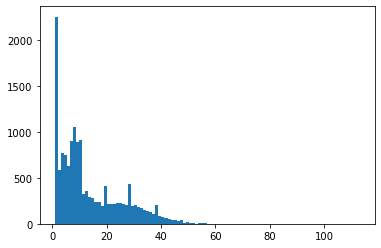

In [12]:
import matplotlib.pyplot as plt

lengths=[]

for i in y_data:
    lengths.append(len(i))

%matplotlib inline
plt.hist(lengths,bins=100)

In [ ]:
from tensorflow.keras.preprocessing import sequence
import numpy as np

# 90th percentile of words
max_sentence_length = int(np.percentile(lengths, 90));

X = sequence.pad_sequences(X_data, maxlen=max_sentence_length);
y = sequence.pad_sequences(y_data, maxlen=max_sentence_length, value = 9);
print("99th Percentile Sentence Word Count (Maximum):",max_sentence_length, "words")

# LSTM Model (for testing functions)

In [14]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import add
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda
from tensorflow.keras.layers import SimpleRNN

embedding_vector_length = 100 # word embeddings should be between 100 and 300
vocabulary_size = len(word_map)
n_tags = len(target_map)

model = Sequential()
model.add(Embedding(vocabulary_size, embedding_vector_length, input_length=max_sentence_length)) # training the word vectors
model.add(LSTM(units=500, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))
model.add(TimeDistributed(Dense(n_tags+1, activation="softmax")))
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 100)           1900300   
_________________________________________________________________
lstm (LSTM)                  (None, 32, 500)           1202000   
_________________________________________________________________
time_distributed (TimeDistri (None, 32, 11)            5511      
Total params: 3,107,811
Trainable params: 3,107,811
Non-trainable params: 0
_________________________________________________________________


In [16]:
train_size = int(round((len(X_data)*0.7),0)) # 70/30 split

In [17]:
import numpy as np
batch_size=300
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)
historyA = model.fit(np.array(X_train), np.array(y_train), validation_data=(np.array(X_val), np.array(y_val)), batch_size=batch_size, epochs=15, verbose=1)

Train on 10490 samples, validate on 4496 samples
Epoch 1/15
10490/10490 [==============================] - 3s 326us/sample - loss: 1.1659 - acc: 0.7097 - val_loss: 0.5854 - val_acc: 0.8745
Epoch 2/15
10490/10490 [==============================] - 3s 262us/sample - loss: 0.4600 - acc: 0.9014 - val_loss: 0.4386 - val_acc: 0.9131
Epoch 3/15
10490/10490 [==============================] - 3s 262us/sample - loss: 0.3733 - acc: 0.9211 - val_loss: 0.3943 - val_acc: 0.9193
Epoch 4/15
10490/10490 [==============================] - 3s 264us/sample - loss: 0.3359 - acc: 0.9236 - val_loss: 0.3604 - val_acc: 0.9199
Epoch 5/15
10490/10490 [==============================] - 3s 262us/sample - loss: 0.2920 - acc: 0.9265 - val_loss: 0.3278 - val_acc: 0.9238
Epoch 6/15
10490/10490 [==============================] - 3s 267us/sample - loss: 0.2540 - acc: 0.9370 - val_loss: 0.3105 - val_acc: 0.9266
Epoch 7/15
10490/10490 [==============================] - 3s 265us/sample - loss: 0.2305 - acc: 0.9433 - val_lo

In [18]:
scores = model.evaluate(np.array(X_val), np.array(y_val), verbose=0)
print("Mean Accuracy: %.2f%%" % (scores[1]*100))

Mean Accuracy: 93.67%


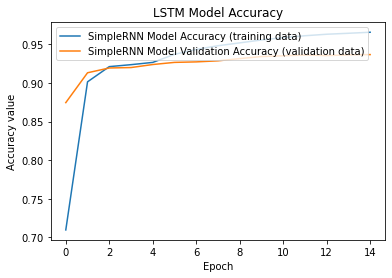

In [19]:
plt.plot(historyA.history['acc'], label='SimpleRNN Model Accuracy (training data)')
plt.plot(historyA.history['val_acc'], label='SimpleRNN Model Validation Accuracy (validation data)')
plt.title('LSTM Model Accuracy')
plt.ylabel('Accuracy value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

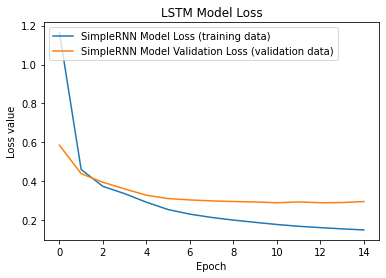

In [20]:
plt.plot(historyA.history['loss'], label='SimpleRNN Model Loss (training data)')
plt.plot(historyA.history['val_loss'], label='SimpleRNN Model Validation Loss (validation data)')
plt.title('LSTM Model Loss')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

In [21]:
preds = model.predict_classes(X_val)
actual = y_val.reshape(len(y_val), max_sentence_length)

In [22]:
flat_actuals = []
flat_preds = []

for i in range(len(actual)): #Traversing through the main list
  for j in range (len(actual[i])): #Traversing through each sublist
    flat_actuals.append(actual[i][j]) #Appending elements into our flat_list

for n in range(len(preds)): #Traversing through the main list
  for m in range (len(preds[n])): #Traversing through each sublist
    flat_preds.append(preds[n][m]) #Appending elements into our flat_list

In [23]:
from sklearn.metrics import classification_report

print(classification_report(flat_actuals, flat_preds));

              precision    recall  f1-score   support

           0       0.57      0.40      0.47      1679
           1       0.91      0.95      0.93     53914
           2       0.59      0.30      0.39      1059
           3       0.57      0.30      0.39      1898
           4       0.58      0.33      0.42      1287
           5       0.66      0.50      0.57      2196
           6       0.54      0.37      0.44      1123
           7       0.75      0.33      0.46       357
           8       0.60      0.25      0.35       407
           9       0.98      1.00      0.99     79952
          10       0.00      0.00      0.00         0

    accuracy                           0.94    143872
   macro avg       0.61      0.43      0.49    143872
weighted avg       0.93      0.94      0.93    143872



/home/pablo/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Including Named Entity 'O', Excluding Padding:

In [24]:
count = 0
total = 0
pred = []
actual = []

for prediction in range(preds.shape[0]):
    for i in range(max_sentence_length):
        if y_val[prediction][i] == 9:
            pass
        else: # if not a padding data point
            if y_val[prediction][i] == preds[prediction][i]:
                count = count+1 # count the true positives
            total = total + 1
            pred.append(preds[prediction][i])
            actual.append(y_val[prediction][i])

### Accuracy (Correct Predictions / All Predictions) where Named Entity 'O' Included, Padding Excluded:

In [25]:
print("Accuracy: %.2f%%" % (100*(count/total)))

Accuracy: 86.04%


In [26]:
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_map.keys()))
    plt.xticks(tick_marks, reverse_target_map.keys(), rotation=45)
    plt.yticks(tick_marks, reverse_target_map.keys())
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [27]:
my_list = map(lambda x: x[0], actual)
actuals = pd.Series(my_list)

d = {'Preds': pd.Series(pred), 'Actuals': pd.Series(actuals)}
df = pd.DataFrame(d)

df = df[df['Actuals'] != 9]
df = df[df['Actuals'] != 1]
df = df[df['Preds'] != 9]
df = df[df['Preds'] != 1]

In [28]:
flat_y_val = df['Actuals'].tolist()
flat_preds = df['Preds'].tolist()

Confusion Matrix - Non-Normalized:

Confusion matrix, without normalization
[[ 668   26   18   20   73   28    0    5    0]
 [  71  314    5    6   20   10    9    1    0]
 [  41    7  566   57   20    9    0    1    3]
 [  13    2  140  427    2   15    0    1    3]
 [  70   19    7   14 1091    4    1    0    1]
 [  86   14   10   14   25  410    7   20    0]
 [   7   23    1    1    7   28  117    0    1]
 [  22    3    3    4   55   75    4  101    0]
 [   0    0    0    0    0    0    0    0    0]]


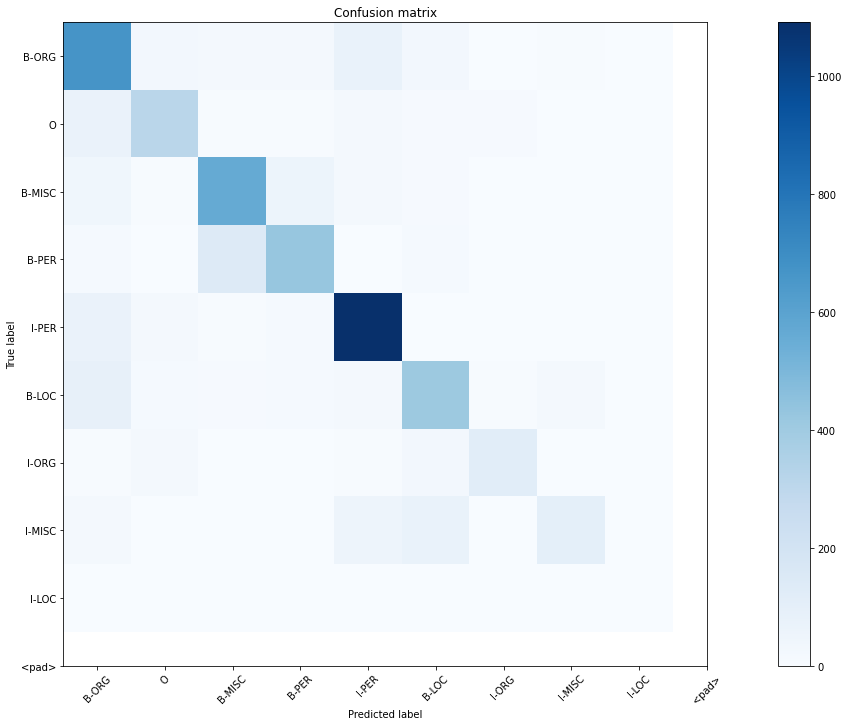

In [29]:
from sklearn.metrics import confusion_matrix
# Compute confusion matrix
#cm = confusion_matrix(actual, pred)
cm = confusion_matrix(flat_y_val, flat_preds)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure(figsize=(20,10))
plot_confusion_matrix(cm)

Confusion Matrix - Normalized:

Normalized confusion matrix
[[7.97e-01 3.10e-02 2.15e-02 2.39e-02 8.71e-02 3.34e-02 0.00e+00 5.97e-03
  0.00e+00]
 [1.63e-01 7.20e-01 1.15e-02 1.38e-02 4.59e-02 2.29e-02 2.06e-02 2.29e-03
  0.00e+00]
 [5.82e-02 9.94e-03 8.04e-01 8.10e-02 2.84e-02 1.28e-02 0.00e+00 1.42e-03
  4.26e-03]
 [2.16e-02 3.32e-03 2.32e-01 7.08e-01 3.32e-03 2.49e-02 0.00e+00 1.66e-03
  4.98e-03]
 [5.80e-02 1.57e-02 5.80e-03 1.16e-02 9.04e-01 3.31e-03 8.29e-04 0.00e+00
  8.29e-04]
 [1.47e-01 2.39e-02 1.71e-02 2.39e-02 4.27e-02 7.00e-01 1.19e-02 3.41e-02
  0.00e+00]
 [3.78e-02 1.24e-01 5.41e-03 5.41e-03 3.78e-02 1.51e-01 6.32e-01 0.00e+00
  5.41e-03]
 [8.24e-02 1.12e-02 1.12e-02 1.50e-02 2.06e-01 2.81e-01 1.50e-02 3.78e-01
  0.00e+00]
 [     nan      nan      nan      nan      nan      nan      nan      nan
       nan]]


/home/pablo/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


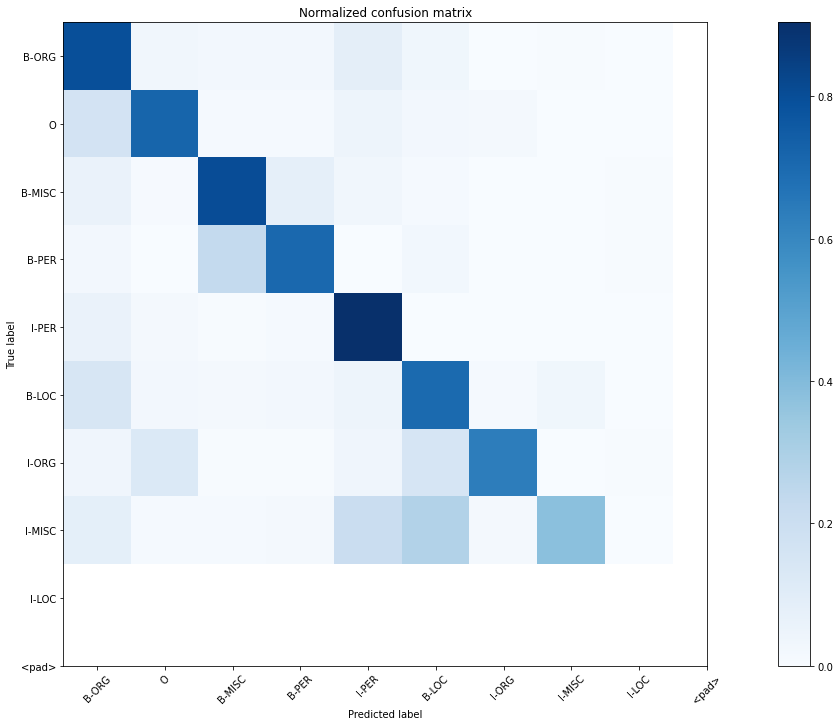

In [30]:
# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure(figsize=(20,10))
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show();

### Excluding Named Entity 'O' and Padding:

In [31]:
count = 0
total = 0
pred = []
actual = []

for prediction in range(preds.shape[0]):
    for i in range(max_sentence_length):
        if (y_val[prediction][i] == 9):
            pass
        if (y_val[prediction][i] == 1):
            pass
        else: # if not a padding data point
            if y_val[prediction][i] == preds[prediction][i]:
                count = count+1 # count the true positives
            total = total + 1
            pred.append(preds[prediction][i])
            actual.append(y_val[prediction][i])

### Accuracy (Correct Predictions / All Predictions) where Named Entity 'O', Padding Excluded:

In [32]:
print("Accuracy: %.2f%%" % (100*(count/total)))

Accuracy: 92.77%


# Bidirectional LSTM

In [ ]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import add
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda
from tensorflow.keras.layers import SimpleRNN

embedding_vector_length = 100 # word embeddings should be between 100 and 300
vocabulary_size = len(word_map)
n_tags = len(target_map)

model2 = Sequential()
model2.add(Embedding(vocabulary_size, embedding_vector_length, input_length=max_sentence_length)) # training the word vectors
model2.add(Bidirectional(LSTM(units=500, return_sequences=True, recurrent_dropout=0.2, dropout=0.2)))
model2.add(TimeDistributed(Dense(n_tags+1, activation="softmax")))
model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
historyB = model2.fit(np.array(X_train), np.array(y_train), validation_data=(np.array(X_val), np.array(y_val)), batch_size=batch_size, epochs=15, verbose=1)

Train on 10490 samples, validate on 4496 samples
Epoch 1/15
10490/10490 [==============================] - 6s 595us/sample - loss: 0.8382 - acc: 0.7954 - val_loss: 0.4559 - val_acc: 0.8927
Epoch 2/15
10490/10490 [==============================] - 5s 486us/sample - loss: 0.3712 - acc: 0.9165 - val_loss: 0.3753 - val_acc: 0.9148
Epoch 3/15
10490/10490 [==============================] - 5s 485us/sample - loss: 0.3286 - acc: 0.9244 - val_loss: 0.3550 - val_acc: 0.9184
Epoch 4/15
10490/10490 [==============================] - 5s 486us/sample - loss: 0.3064 - acc: 0.9267 - val_loss: 0.3417 - val_acc: 0.9200
Epoch 5/15
10490/10490 [==============================] - 5s 488us/sample - loss: 0.2814 - acc: 0.9278 - val_loss: 0.3215 - val_acc: 0.9213
Epoch 6/15
10490/10490 [==============================] - 5s 490us/sample - loss: 0.2491 - acc: 0.9302 - val_loss: 0.2994 - val_acc: 0.9255
Epoch 7/15
10490/10490 [==============================] - 5s 488us/sample - loss: 0.2155 - acc: 0.9383 - val_lo

In [ ]:
scores = model2.evaluate(np.array(X_val), np.array(y_val), verbose=0)
print("Mean Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
plt.plot(historyB.history['acc'], label='SimpleRNN Model Accuracy (training data)')
plt.plot(historyB.history['val_acc'], label='SimpleRNN Model Validation Accuracy (training data)')
plt.title('Bidirectional LSTM Model Accuracy')
plt.ylabel('Accuracy value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
plt.plot(historyB.history['loss'], label='SimpleRNN Model Loss (training data)')
plt.plot(historyB.history['val_loss'], label='SimpleRNN Model Validation Loss (training data)')
plt.title('Bidirectional LSTM Model Loss')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
preds_LSTM = model2.predict_classes(X_val)
actual = y_val.reshape(len(y_val), max_sentence_length)

In [ ]:
flat_actuals = []
flat_preds_LSTM = []

for i in range(len(actual)): #Traversing through the main list
  for j in range (len(actual[i])): #Traversing through each sublist
    flat_actuals.append(actual[i][j]) #Appending elements into our flat_list

for n in range(len(preds_LSTM)): #Traversing through the main list
  for m in range (len(preds_LSTM[n])): #Traversing through each sublist
    flat_preds_LSTM.append(preds_LSTM[n][m]) #Appending elements into our flat_list

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(flat_actuals, flat_preds_LSTM));

In [ ]:
count = 0
total = 0
pred = []
actual = []

for prediction in range(preds_LSTM.shape[0]):
    for i in range(max_sentence_length):
        if y_val[prediction][i] == 9:
            pass
        else: # if not a padding data point
            if y_val[prediction][i] == preds_LSTM[prediction][i]:
                count = count+1 # count the true positives
            total = total + 1
            pred.append(preds_LSTM[prediction][i])
            actual.append(y_val[prediction][i])

### Accuracy (Correct Predictions / All Predictions) where Named Entity 'O' Included, Padding Excluded:

In [ ]:
print("Accuracy: %.2f%%" % (100*(count/total)))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_map.keys()))
    plt.xticks(tick_marks, reverse_target_map.keys(), rotation=45)
    plt.yticks(tick_marks, reverse_target_map.keys())
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
my_list = map(lambda x: x[0], actual)
actuals = pd.Series(my_list)

d = {'Preds': pd.Series(pred), 'Actuals': pd.Series(actuals)}
df = pd.DataFrame(d)

df = df[df['Actuals'] != 9]
df = df[df['Actuals'] != 1]
df = df[df['Preds'] != 9]
df = df[df['Preds'] != 1]

In [ ]:
flat_y_val = df['Actuals'].tolist()
flat_preds = df['Preds'].tolist()

Confusion Matrix - Non-Normalized:

In [ ]:
from sklearn.metrics import confusion_matrix
# Compute confusion matrix
#cm = confusion_matrix(actual, pred)
cm = confusion_matrix(flat_y_val, flat_preds)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure(figsize=(20,10))
plot_confusion_matrix(cm)

In [ ]:
# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure(figsize=(20,10))
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show();

### Excluding Named Entity 'O' and Padding:

### Accuracy (Correct Predictions / All Predictions) where Named Entity 'O', Padding Excluded:

In [ ]:
count = 0
total = 0
pred = []
actual = []

for prediction in range(preds_LSTM.shape[0]):
    for i in range(max_sentence_length):
        if (y_val[prediction][i] == 9):
            pass
        if (y_val[prediction][i] == 1):
            pass
        else: # if not a padding data point
            if y_val[prediction][i] == preds_LSTM[prediction][i]:
                count = count+1 # count the true positives
            total = total + 1
            pred.append(preds_LSTM[prediction][i])
            actual.append(y_val[prediction][i])

In [ ]:
print("Accuracy: %.2f%%" % (100*(count/total)))

# Final Assessment: LSTM vs. Bidirectional LSTM
Overall, the Bidirectional LSTM outperformed the LSTM both with and without the Named Entity 'O' present in the data. However, without 'O', the LSTM slightly outperformed the Bidirection LSTM, in terms of accuracy. Nonetheless, the overall (average between with and without 'O') accuracy was slightly higher for the Bidirectional LSTM.

Overall, the LSTM and the Bidirectional LSTM both performed very similarly. With more data, perhaps there would be greater separation between the results of the two. With respect to confusion matrix report values, there were only very minor differences across each metric, by target class. The most notable difference for precision is on class 8 (I-ORG); the Bidirectional LSTM precision for this class was 0.69 and only 0.33 for the unidirectional LSTM. There were no noteable discernments when comparing recall between the two networks.

Regarding accuracy, the Bidirectional LSTM again very slightly outperformed the unidirectional LSTM. The mean accuracy for the Bidirectional LSTM was 94.09% whereas the unidirectional LSTM scored a mean accuracy of 93.40%. One notable exception is that when target class 'O' was removed, the Bidirectional LSTM - across several repeats - scored slightly less (~0.39% less) than the unidirectional LSTM. Likely, the Bidirectional's observance of the imbalance produced a minor overfit to that target class. Balancing the data would most likely resolve this issue, which may be of consideration going forward as more data introduces greater separation between the models; where the Bidirectional LSTM seemed to overall perform better, balancing may be of greater concern - since it is bidirectional - as a higher volume of data is introduced.